In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *

set_rc_params()

np.random.seed(3)
torch.manual_seed(3)

In [2]:
# general parameters
dataset_name = "Tree_Cycle"

model_type = Tree_Cycle_GCN
load_pretrained = True

# hyperparameters
k = 10

# other parameters
train_test_split = 0.8
num_hidden_units = 20
num_classes = 2

epochs = 6000
lr = 0.001

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of edges:  871


AttributeError: 'Tree_Cycle_GCN' object has no attribute 'name'

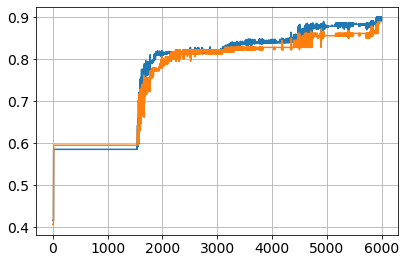

In [4]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split, if_adj=True)
model = model_type(3, data["x"].shape[1], num_hidden_units, num_classes)

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, epochs, lr, paths['base'])

In [ ]:
k = 10

path = "output/tree_cycle/"
path_tsne = os.path.join(path, "TSNE")
path_pca = os.path.join(path, "PCA")
path_kmeans = os.path.join(path, f"{k}_KMeans")
path_hc = os.path.join(path, f"HC")
os.makedirs(path, exist_ok=True)
os.makedirs(path_tsne, exist_ok=True)
os.makedirs(path_pca, exist_ok=True)
os.makedirs(path_kmeans, exist_ok=True)
os.makedirs(path_hc, exist_ok=True)

G, labels = load_syn_data("Tree_Cycle")
data = prepare_syn_data(G, labels, 0.8)
model = Tree_Cycle_GCN(3, data["x"].shape[1], 20, 2)

load_pretrained = True

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load("custom_models/cycle_shape_model.pkl"))
    model.eval()
    
    with open("custom_models/cycle_shape_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    epochs = 6000
    lr = 0.001
    train(model, data, epochs, lr, path)

# TSNE

In [ ]:
# TSNE conversion
tsne_models = []
tsne_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "TSNE-Reduced", layer_num, path_tsne, "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

# PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA-Reduced", layer_num, path_pca, "(coloured by labels)")
    
    pca_models.append(pca_model)
    pca_data.append(d)

# Perform KMeans Clustering

In [ ]:
num_nodes_view = 5
num_expansions = 3
edges = data['edge_list'].numpy()

raw_sample_graphs = []
raw_sample_feat = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "KMeans", k, layer_num, path_kmeans, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "KMeans", k, layer_num, path_kmeans, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "KMeans-Raw", num_nodes_view, edges, num_expansions, path_kmeans)
    
    raw_sample_graphs.append(sample_graphs)
    raw_kmeans_models.append(kmeans_model)
    

In [ ]:
tsne_sample_graphs = []
tsne_sample_feat = []
tsne_kmeans_models = []
for layer_num, item in enumerate(tsne_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, layer_num, path_kmeans, "TSNE")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "KMeans-TSNE", num_nodes_view, edges, num_expansions, path_kmeans)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    
pca_sample_graphs = []
pca_sample_feat = []
pca_kmeans_models = []
for item in pca_data:
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, layer_num, path_kmeans, "PCA")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "KMeans-PCA", num_nodes_view, edges, num_expansions, path_kmeans)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

In [ ]:
# tree_heuristics = Tree_Cycle_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "KMeans-Raw", path_kmeans)
    
# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "KMeans-TSNE", path_kmeans)
    
# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "KMeans-PCA", path_kmeans)
    

# Perform Hierarchical Clustering

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "Raw", layer_num, path_hc)

In [ ]:
raw_n_clusters = [3, 3, 18, 20]

raw_sample_graphs = []
raw_sample_feat = []
raw_hc_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(activation)
    
    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC-Raw", num_nodes_view, edges, num_expansions, path_hc)
    
    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_hc_models.append(hc)

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "TSNE", layer_num, path_hc)

In [ ]:
tsne_n_clusters = [7, 12, 20, 20]

tsne_sample_graphs = []
tsne_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "TSNE")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC-TSNE", num_nodes_view, edges, num_expansions, path_hc)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)
    

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, path_hc)

In [ ]:
pca_n_clusters = [7, 12, 20, 20]

pca_sample_graphs = []
pca_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC-PCA", num_nodes_view, edges, num_expansions, path_hc)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "HC-Raw", path_hc)
    
# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "HC-TSNE", path_hc)
    
# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(tree_heuristics, sample, layer_num, "HC-PCA", path_hc)
    

# Activation to Concept to Class

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["Kmeans", "Raw", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_kmeans, i, k, "Raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["Kmeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_kmeans, i, k, "TSNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["Kmeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_kmeans, i, k, "PCA")
    
# plot_completeness_table("Kmeans", "Decision Tree", completeness_scores, path_kmeans)
    

In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["KMeans", "Raw", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, k, "Raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["KMeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, k, "TSNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["KMeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, k, "PCA")
    
# plot_completeness_table("KMeans", "Logistic Regression", completeness_scores, path_kmeans)
    

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "Raw")
    
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "PCA")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, path_hc)


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "Raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "TSNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["edge_list"], i)
    
#     d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(path_hc, i, n, "PCA")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, path_hc)
    

# Graph Similarity

In [ ]:
graph_scores = []
view = 3

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, i, k, "KMeans-Raw", view, edges, num_expansions, path_kmeans)
        
for i, item in enumerate(tsne_data):    
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_kmeans_models[i], item, i, k, "KMeans-TSNE", view, edges, num_expansions, path_kmeans)
    
for i, item in enumerate(pca_data):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_kmeans_models[i], item, i, k, "KMeans-PCA", view, edges, num_expansions, path_kmeans)


    
plot_graph_similarity_table("Kmeans", graph_scores, path_kmeans)
    

In [ ]:
graph_scores = []
view = 3
max_nodes = 15

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)
    
    for k_idx in range(n):        
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC-Raw", view, edges, num_expansions, path_hc)
        
        
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC-TSNE", view, edges, num_expansions, path_hc)
        

        
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC-PCA", view, edges, num_expansions, path_hc)
        
    
plot_graph_similarity_table("HC", graph_scores, path_hc)
    

# GNNExplainer

In [ ]:
# node_idx = 572

# # convert to edge format
# edges = edge_list.transpose(0, 1).t().contiguous()

# explainer = GNNExplainer2(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, node_data_x, edges)

In [ ]:
# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=node_data_y, threshold=0.8)
# plt.show()